In [1]:
# Step 1: Install kaggle if it's not already installed
!pip install kaggle

# Step 2: Upload the kaggle.json file (Kaggle API key) to Colab
from google.colab import files
files.upload()  # Choose the kaggle.json file from your local machine

# Step 3: Move kaggle.json to the appropriate directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4: Download the dataset
!kaggle datasets download -d rm1000/lung-cancer-histopathological-images -p /content/dataset --unzip

# Step 5: Check if files are downloaded
import os
print("Files in dataset folder:", os.listdir("/content/dataset"))


Saving kaggle (1).json to kaggle (1).json
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/rm1000/lung-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.55G/1.55G [01:11<00:00, 23.5MB/s]
100% 1.55G/1.55G [01:11<00:00, 23.4MB/s]
Files in dataset folder: ['squamous_cell_carcinoma', 'adenocarcinoma', 'benign']


In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
train_data = datasets.ImageFolder(root='/content/dataset', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)


# Pre-Trained Model|

In [3]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=3)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Preparing the training loop

Set up the training loop with an optimizer, a loss function (e.g., cross-entropy), and any evaluation metrics you want to track (accuracy, F1-score, etc.).

In [4]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

optimizer = Adam(model.parameters(), lr=3e-5)
loss_fn = CrossEntropyLoss()

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

# Splitting dataset

In [5]:
from torch.utils.data import DataLoader, random_split
dataset = datasets.ImageFolder(root="/content/dataset", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#

In [6]:
from torch.optim.lr_scheduler import StepLR
num_epochs = 5

scheduler = StepLR(optimizer, step_size=2, gamma=0.1)  # Reduce lr every 2 epochs by factor of 0.1

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch 1/5: 100%|██████████| 375/375 [06:12<00:00,  1.01it/s]


Epoch [1/5], Loss: 0.1402


Epoch 2/5: 100%|██████████| 375/375 [06:08<00:00,  1.02it/s]


Epoch [2/5], Loss: 0.0256


Epoch 3/5: 100%|██████████| 375/375 [06:08<00:00,  1.02it/s]


Epoch [3/5], Loss: 0.0099


Epoch 4/5: 100%|██████████| 375/375 [06:09<00:00,  1.01it/s]


Epoch [4/5], Loss: 0.0090


Epoch 5/5: 100%|██████████| 375/375 [06:09<00:00,  1.02it/s]

Epoch [5/5], Loss: 0.0086


In [7]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = 100 * correct / total
print(f"Validation Accuracy after Epoch {epoch+1}: {val_accuracy:.2f}%")


Validation Accuracy after Epoch 5: 100.00%


# Predictions visualization

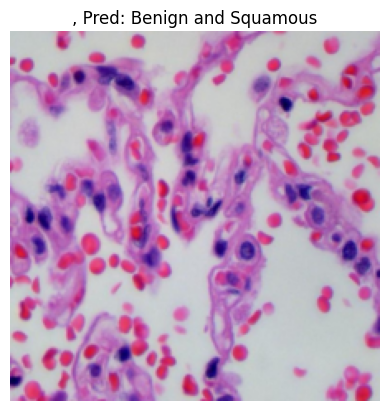

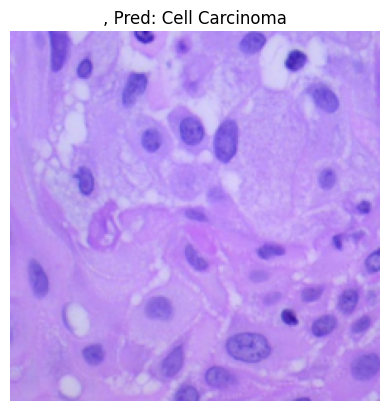

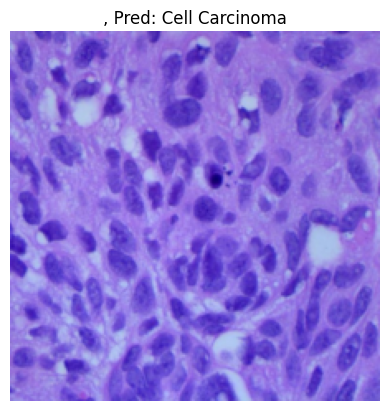

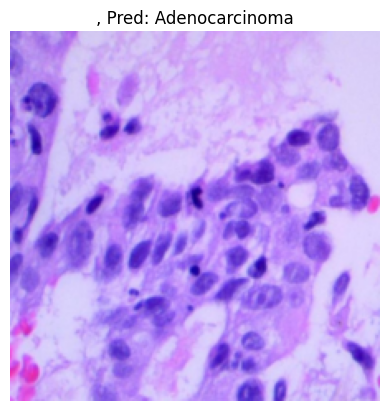

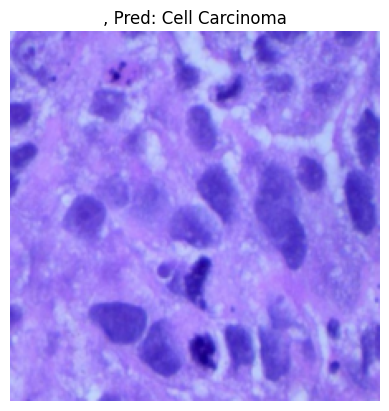

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Example class names list
class_names = ['Adenocarcinoma' ,'Benign and Squamous','Cell Carcinoma']  # Replace with your actual class names

def display_predictions(images, labels, predictions, class_names, num_images=5):
    for i in range(num_images):
        # Prepare image for display
        image = images[i].cpu().numpy().transpose((1, 2, 0))
        image = np.clip((image * 0.5) + 0.5, 0, 1)

        # Get true and predicted class names
        true_class = class_names[labels[i].item()]
        predicted_class = class_names[predictions[i].item()]

        # Plot image with title
        plt.imshow(image)
        plt.title(f", Pred: {predicted_class}")
        plt.axis('off')
        plt.show()

# Sample batch
sample_images, sample_labels = next(iter(val_loader))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)

# Get model predictions
# Get model predictions
sample_outputs = model(sample_images)
# Access the logits from the ImageClassifierOutput object
_, sample_predictions = torch.max(sample_outputs.logits, 1)
# Display predictions with class names
display_predictions(sample_images, sample_labels, sample_predictions, class_names)


# Confusion matrix

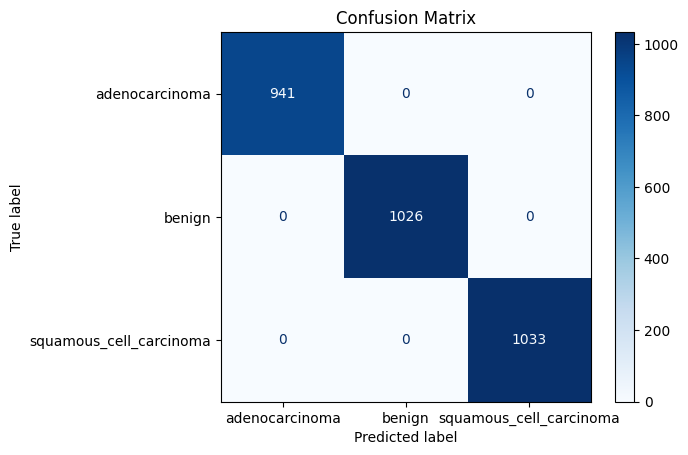

In [15]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to store all labels and predictions
all_labels = []
all_preds = []

# Iterate through the validation data loader
for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)

    # Get model predictions
    outputs = model(images).logits
    _, predictions = torch.max(outputs, 1)

    # Extend the lists with current batch labels and predictions
    all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to NumPy
    all_preds.extend(predictions.cpu().numpy()) # Move predictions to CPU and convert to NumPy

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()